# Customer Insurance Charges EDA & Regression model (ML)

In [115]:
%cd /content/drive/MyDrive/딥러닝기초

/content/drive/MyDrive/딥러닝기초


In [116]:
import pandas as pd

df = pd.read_csv('./insurance.csv', index_col=0)

In [117]:
df.head()

,age,sex,bmi,children,smoker,region,charges
index,,,,,,,
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


> no missing values

# EDA

In [119]:
df.region.unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

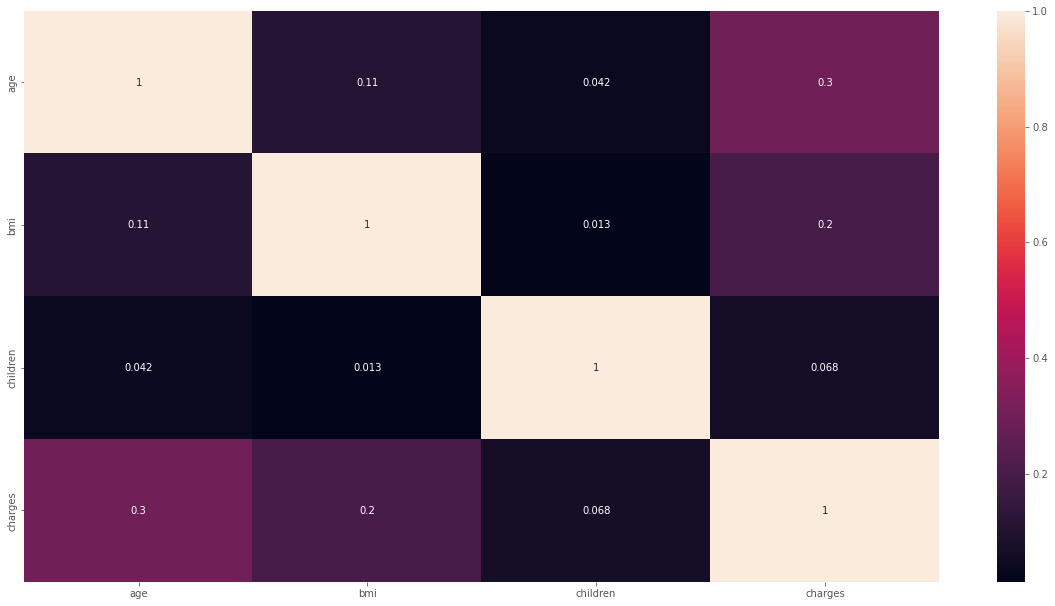

In [120]:
sns.heatmap(df.select_dtypes(['int64','float64']).corr(), annot=True)

Among numeric features age has the strongest correlation with charges, but still 0.3 seems little too low. Let's look at scatter plots.

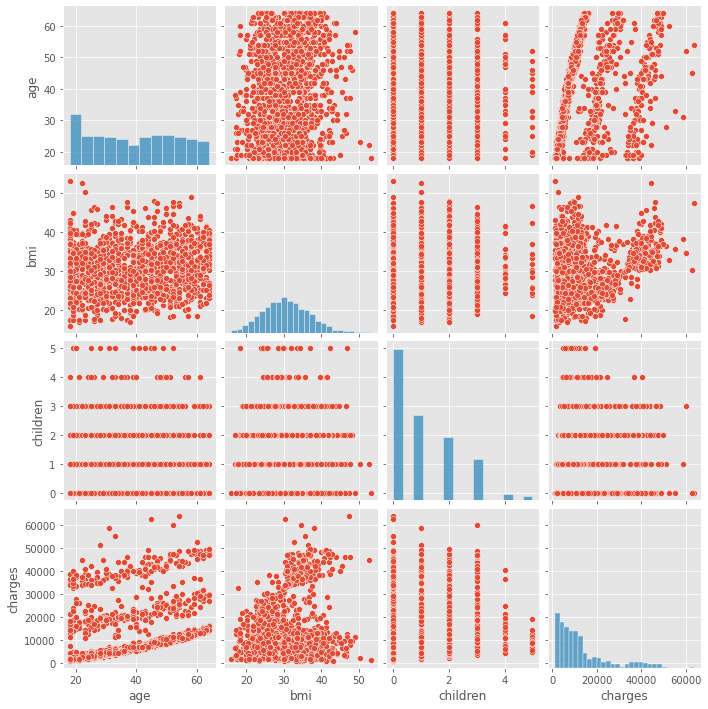

In [121]:
import seaborn as sns

sns.pairplot(df)

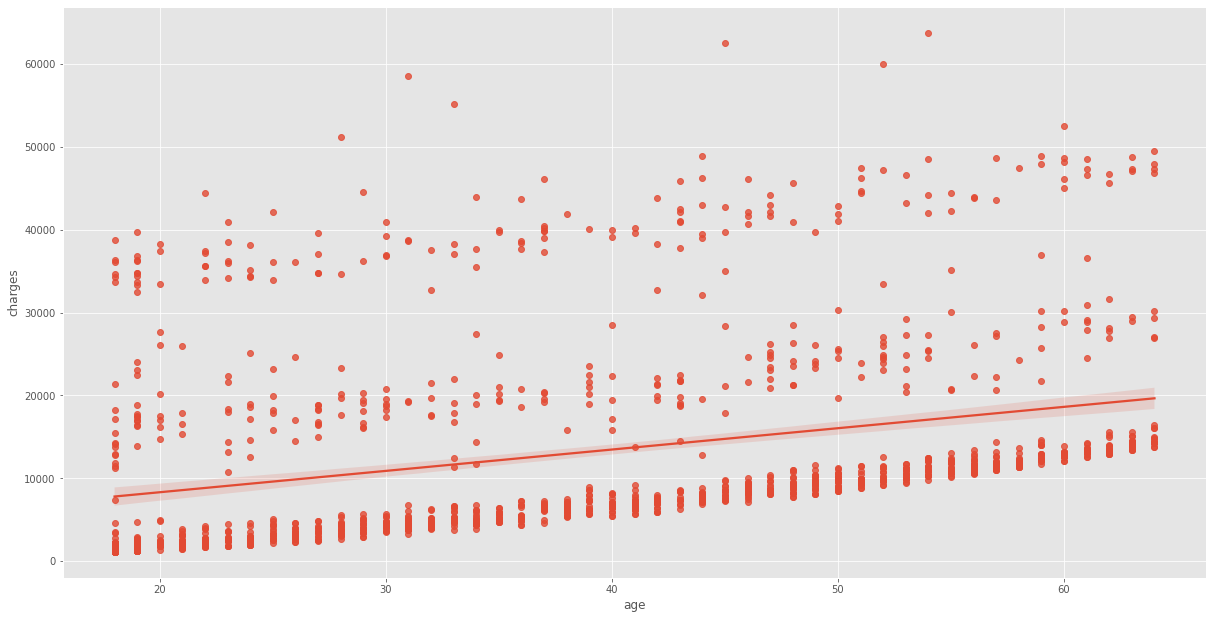

In [122]:
 sns.regplot(x='age',y='charges',data=df)  

It seems like charges between 0 and 1500000 have very strong correlations with age. The older you are, the more you are likely to charge for you insurance.

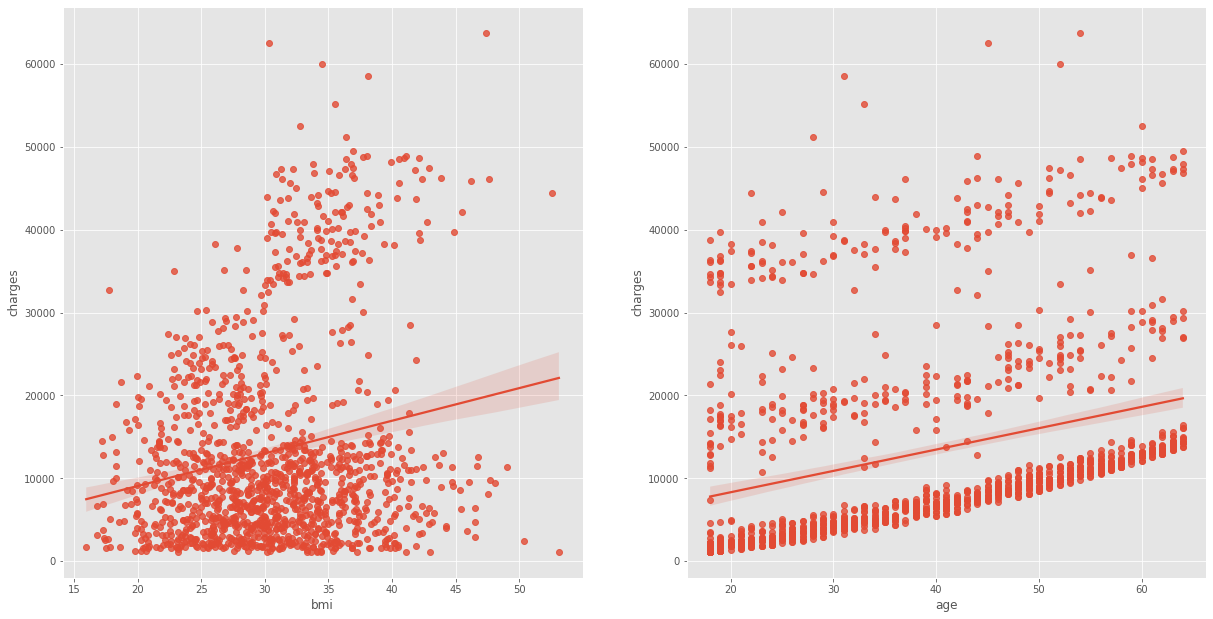

In [123]:
fig, axes = plt.subplots(1, 2)
features = ['bmi','age']
for i,feature in enumerate(features):
    sns.regplot(x=feature,y='charges', data=df, ax=axes[i])   

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


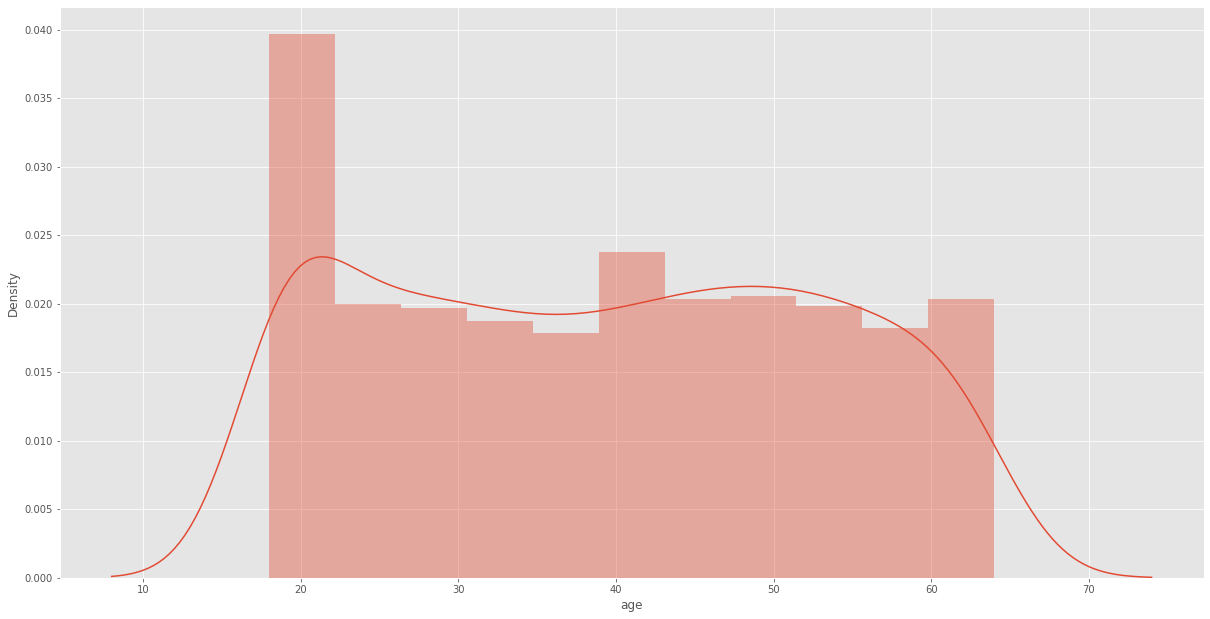

In [124]:
sns.distplot(df.age)

Mostly 20s are in the dataset. 

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


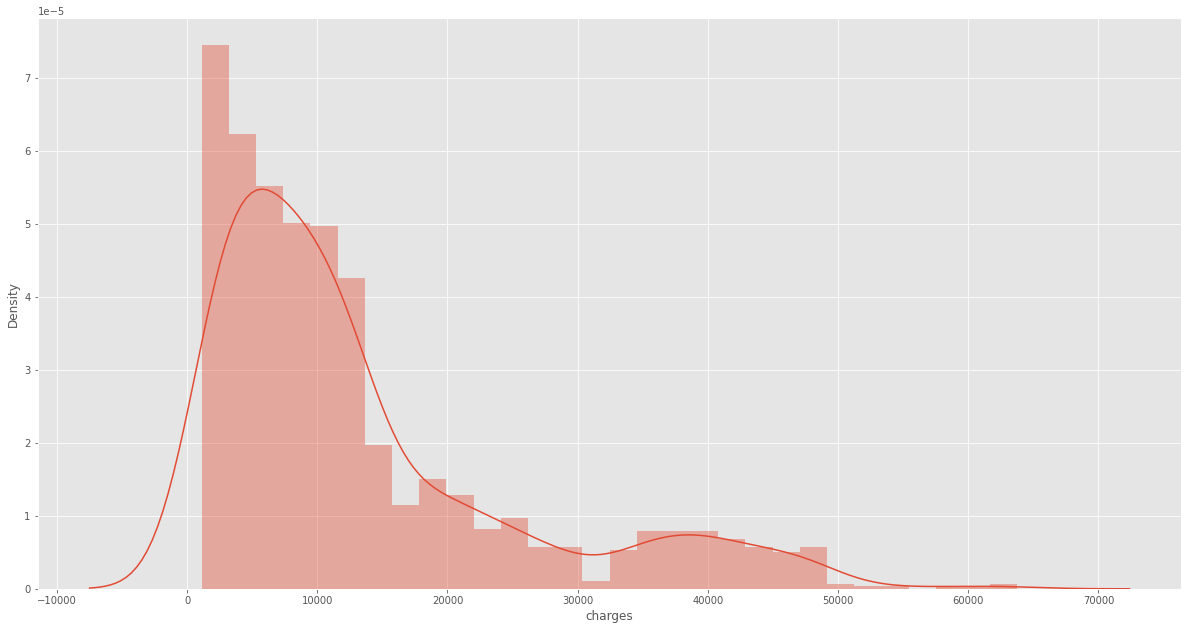

In [125]:
sns.distplot(df.charges)

Mostly between 0 and 15000

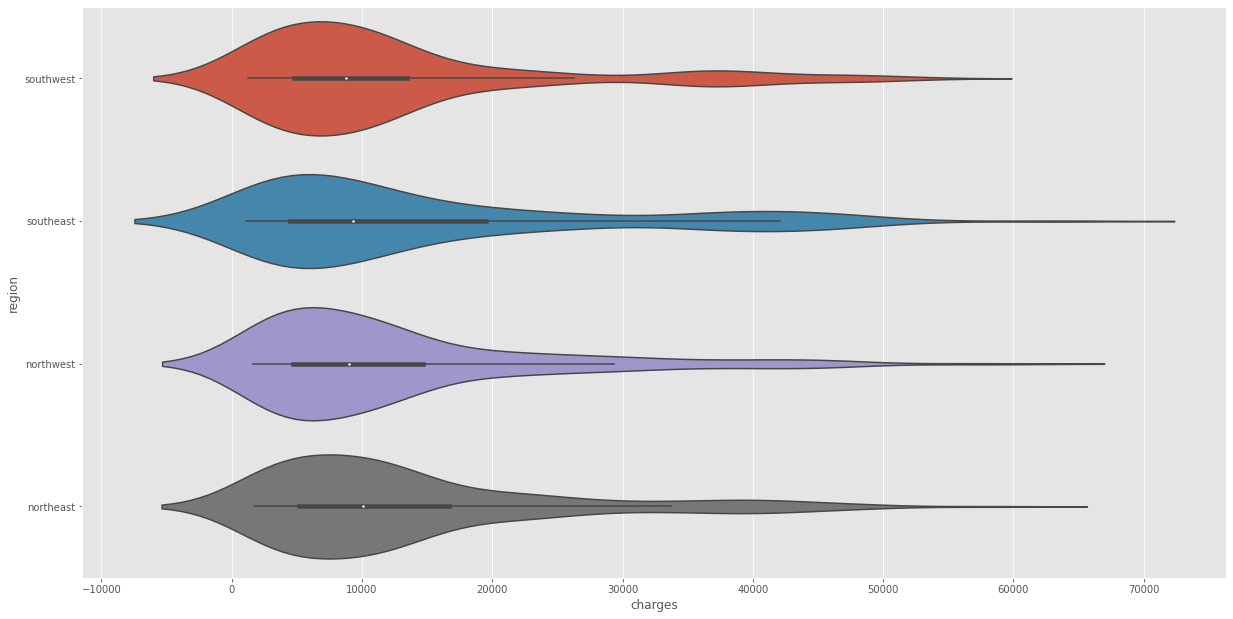

In [126]:
plt.rcParams["figure.figsize"] = [20.50, 10.50]
sns.violinplot(x=df['charges'], y=df['region'])

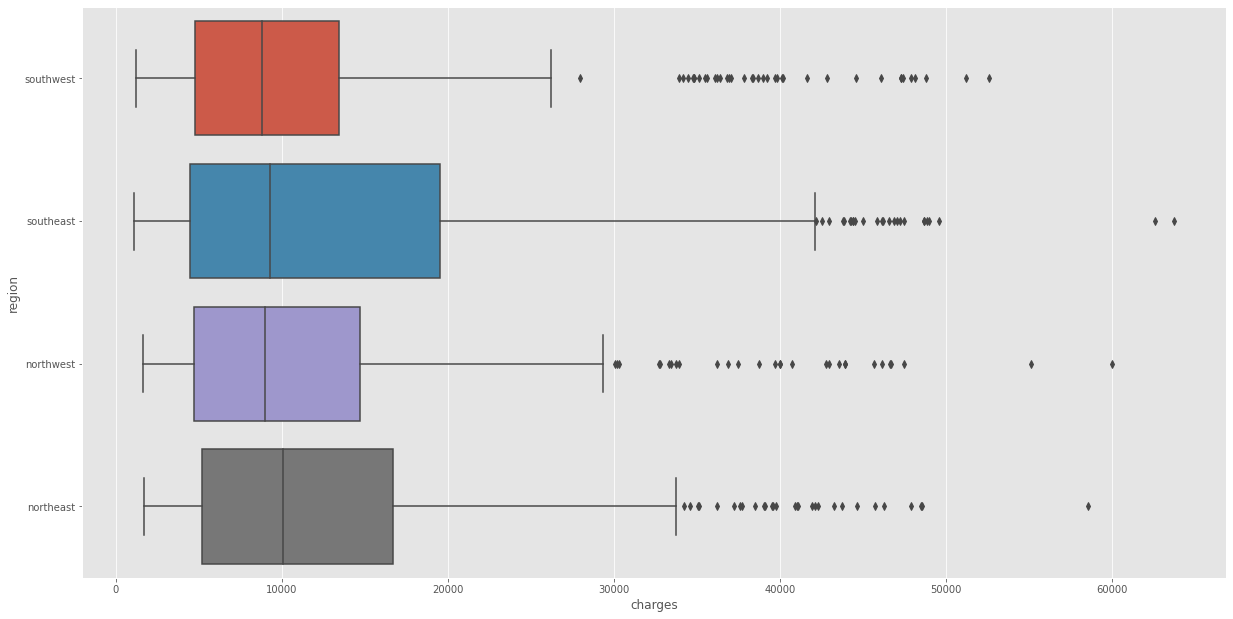

In [127]:
plt.rcParams["figure.figsize"] = [20.50, 10.50]
sns.boxplot(x=df['charges'], y=df['region'])

Southheast region has the highest average charge amount per region. In general, there is a small deffirence between regions in term of charging amount.

# Data processing

Let's do mapping process to change string features to numeric.

In [128]:
sex_mapper = {"female":0, "male":1}
smoker_mapper = {'yes':1, 'no':0}
region_mapper = {'southwest':1, 'southeast':2, 'northwest':3, 'northeast':4}  
df["sex"] = df["sex"].replace(sex_mapper)
df["smoker"] = df["smoker"].replace(smoker_mapper)
df["region"] = df["region"].replace(region_mapper)

Then check the correlation between all features. 

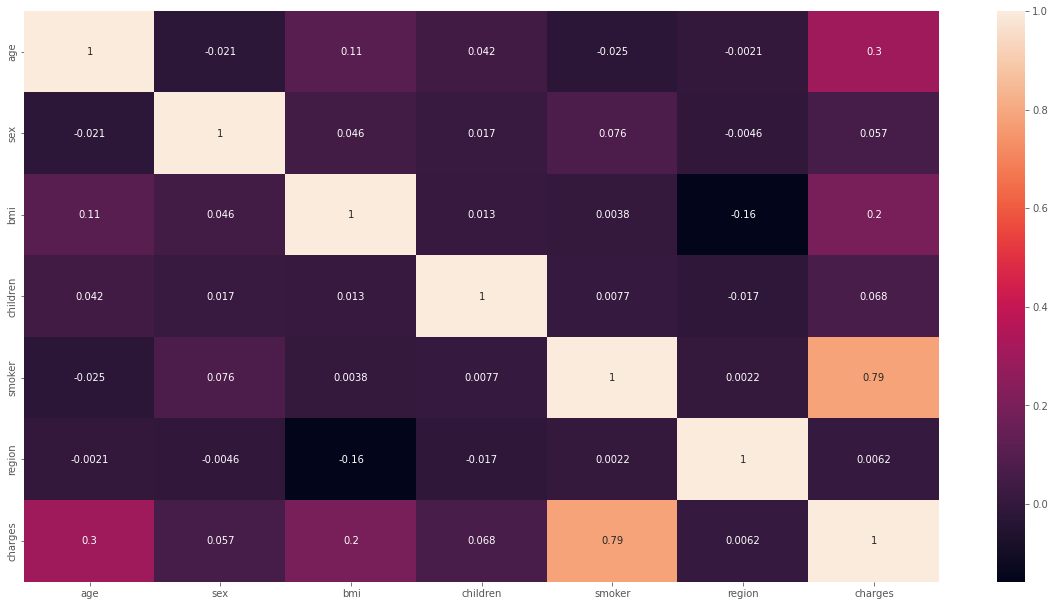

In [129]:
sns.heatmap(df.corr(), annot=True)

It is obvious that smoker feature has high correlation with insurance charges.

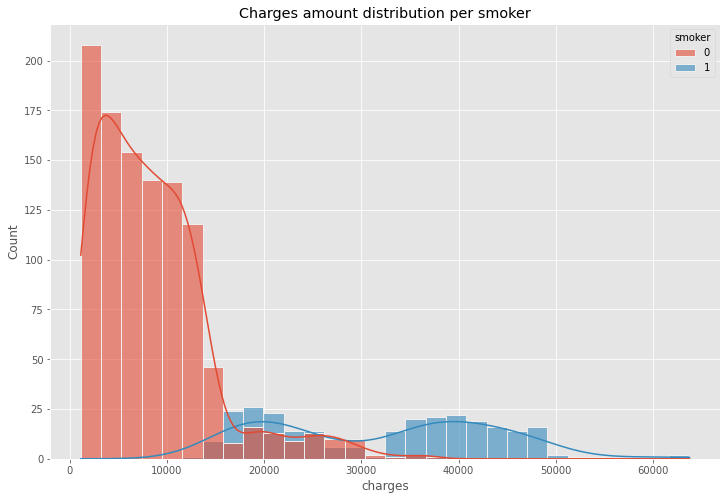

In [130]:
plt.figure(figsize=(12,8))
plt.title('Charges amount distribution per smoker')
sns.histplot(df,x='charges',hue="smoker",kde=True,alpha=0.6,linewidth=1)

Non-smokers charge mostly less than smokers. Charges of smokers are all above 10000.

# Modelling

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from math import sqrt

In [132]:
y_target = df['charges']
X_data = df.drop(columns='charges')

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.15, random_state = 100)

In [134]:
gbr = GradientBoostingRegressor()

In [135]:
model = gbr

n_estimators = [100, 500, 900, 1100, 1500]
max_depth = [2, 3, 5, 10, 15]
learning_rate=[0.05,0.1,0.15,0.20]
max_features=[2,4,6,8,10]

hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'max_features':max_features,
    'learning_rate':learning_rate
    }

Here we will use RandomizedSearchCV.

Grid Search is good when we work with a small number of hyperparameters. However, if the number of parameters to consider is particularly high and the magnitudes of influence are imbalanced, the better choice is to use the Random Search.

In [136]:
random_cv = RandomizedSearchCV(estimator=gbr,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

In [137]:
random_cv.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py", line 586, in fit
    n_stages = self._fit_stages(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py", line 663, in _fit_stages
    raw_predictions = self._fit_stage(
  File "/usr/local/lib/python3.8/dist-packages/sklearn/en

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=50,
                   n_jobs=4,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [2, 3, 5, 10, 15],
                                        'max_features': [2, 4, 6, 8, 10],
                                        'n_estimators': [100, 500, 900, 1100,
                                                         1500]},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=5)

Let's get the best parameters for the model.

In [138]:
random_cv.best_params_

{'n_estimators': 100, 'max_features': 4, 'max_depth': 3, 'learning_rate': 0.05}

We train the model with the best parameters.

In [139]:
gbr = GradientBoostingRegressor(n_estimators= 100,max_features= 4, max_depth= 3, learning_rate= 0.05)

In [140]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_features=4)

Now, we will test our final model and calculate the mse to check how accurate the model can predict insurance charges based on the given customer characteristics in the test data.

In [141]:
ypred = gbr.predict(X_test)
mse = mean_squared_error(y_test,ypred)
rmse = sqrt(mse)
rmse

3991.266601796602

In [142]:
score1 = gbr.score(X_train,y_train)
score1

0.8808559717742332

We can also calculate r2 score. 

"R-Squared (R² or the coefficient of determination) is a statistical measure in a regression model that determines the proportion of variance in the dependent variable that can be explained by the independent variable. In other words, r-squared shows how well the data fit the regression model (the goodness of fit)."

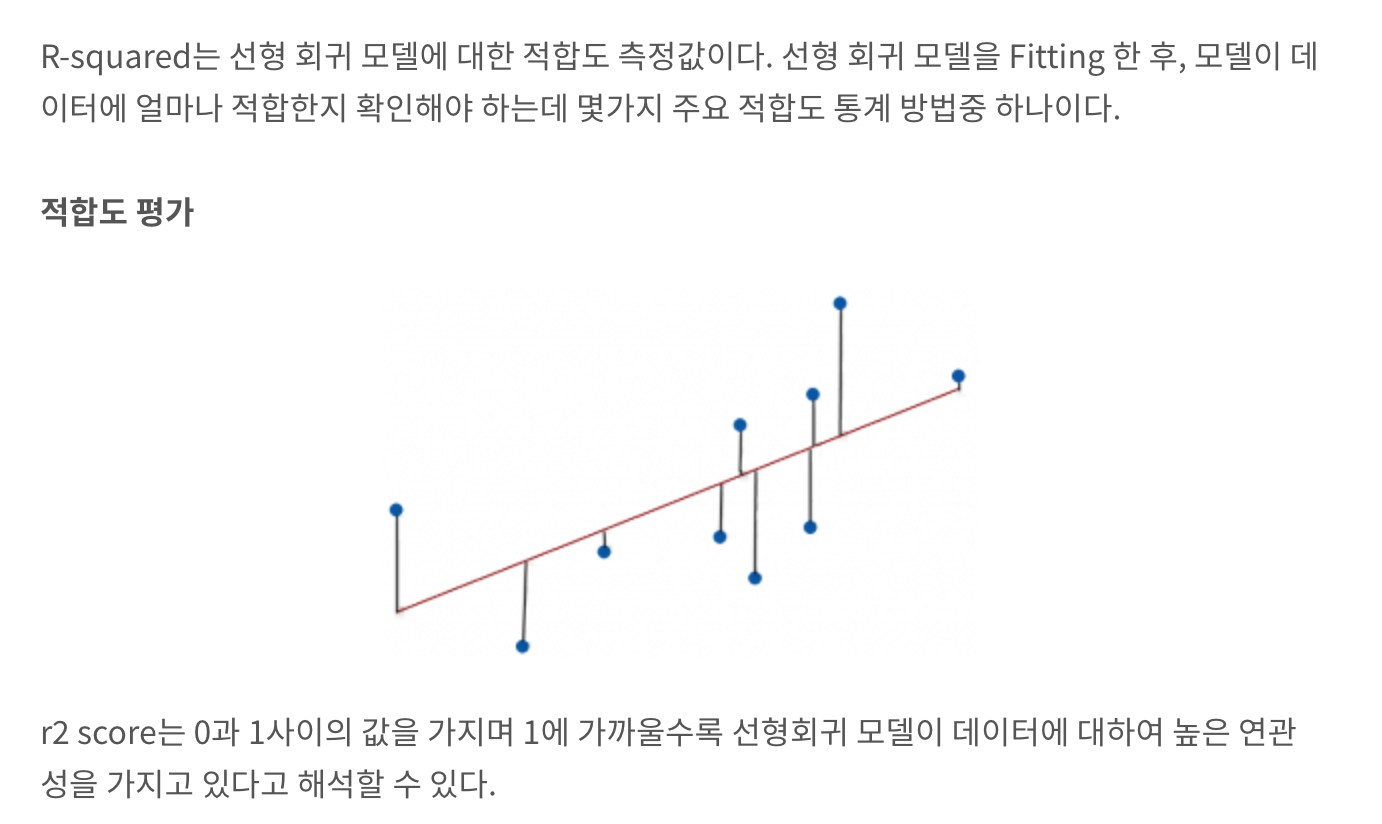

In [143]:
y_pred1 = gbr.predict(X_test)
rscore1=r2_score(y_test, y_pred1)
round(rscore1,2)

0.89

# Plot comparison

We will plot the predicted charges with the original charges in the training dataset to see the differences.

In [144]:
df2=df.copy()

In [145]:
df2['pred']=gbr.predict(X_data)

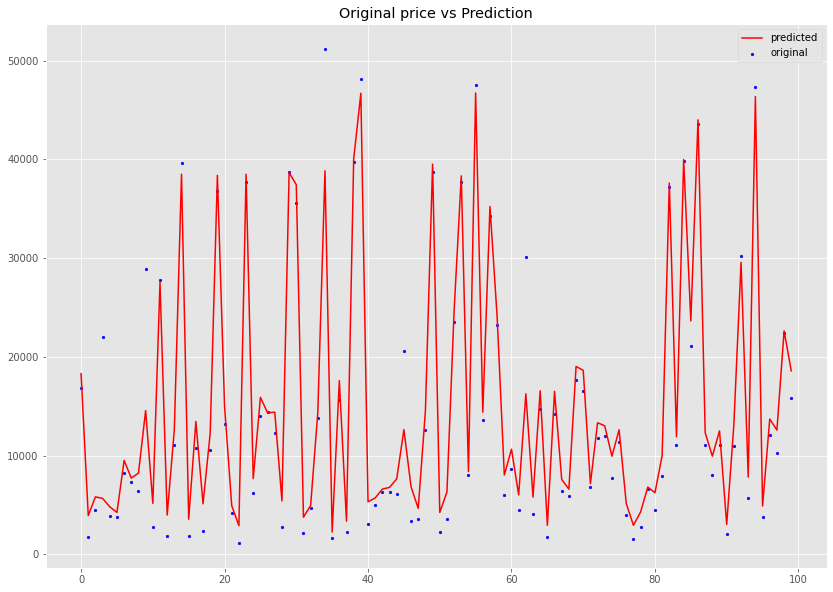

In [146]:
x_ax = range(len(df2['pred'].head(100)))
plt.figure(figsize=(14,10))
plt.title('Original price vs Prediction')
plt.scatter(x_ax, df2['charges'].head(100), s=7, color="blue", label="original")
plt.plot(x_ax, df2['pred'].head(100), lw=1.5, color="red", label="predicted")
plt.legend()
plt.show()